In [1]:
import tensorflow as tf

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:

# test_path = os.path.dirname("test_images")

test_img_paths = sorted(
    [
        os.path.join("test_images", fname)
        for fname in os.listdir("test_images")
        if fname.endswith(".JPG") or fname.endswith(".jpg") or fname.endswith(".jpeg")
    ]
)

In [3]:
test_img_paths

['test_images/1.jpg',
 'test_images/1_2.JPG',
 'test_images/2.jpg',
 'test_images/2_2.jpg',
 'test_images/2_3.jpg',
 'test_images/3.jpg',
 'test_images/3_2.jpg',
 'test_images/3_3.jpg',
 'test_images/3_4.jpg',
 'test_images/3_5.jpg',
 'test_images/4.JPG',
 'test_images/4.jpeg',
 'test_images/4.jpg',
 'test_images/4_1.jpeg',
 'test_images/4_2.jpg',
 'test_images/4_3.jpg',
 'test_images/4_4.JPG',
 'test_images/4_5.jpg',
 'test_images/4_6.jpg',
 'test_images/5.JPG',
 'test_images/5_2.JPG',
 'test_images/5_3.JPG']

In [4]:

  
import torch
import piq
from skimage.io import imread

In [5]:
x = torch.tensor(imread('test_images/1.jpg')).permute(2, 0, 1)[None, ...] / 255.

In [6]:
brisque_index: torch.Tensor = piq.brisque(x, data_range=1., reduction='none')

In [7]:
brisque_loss: torch.Tensor = piq.BRISQUELoss(data_range=1., reduction='none')(x)
print(f"BRISQUE index: {brisque_index.item():0.4f}, loss: {brisque_loss.item():0.4f}")

BRISQUE index: 41.9486, loss: 41.9486


In [8]:
tv_index: torch.Tensor = piq.total_variation(x)
# In order to use TV as a loss function, use corresponding PyTorch module:
tv_loss: torch.Tensor = piq.TVLoss(reduction='none')(x)
print(f"TV index: {tv_index.item():0.4f}, loss: {tv_loss.item():0.4f}")

TV index: 43.6095, loss: 43.6095


In [9]:
import torch
from torch import nn
from torchvision import models
from torchvision import transforms
from PIL import Image
import os
import numpy as np

def rate(img_path):
    """
    Returns: Scores, mean, std
    """
    # Number of classes in the dataset
    num_classes = 10

    model_ft = models.densenet121(pretrained=True)
    num_ftrs = model_ft.classifier.in_features
    model_ft.classifier = nn.Sequential(
        nn.Linear(num_ftrs,num_classes),
        nn.Softmax(1)
    )

#     Weight Path
#     weight_path = 'NIMA/weights/dense121_all.pt'

#     # Load weights
#     assert os.path.exists(weight_path)
#     model_ft.load_state_dict(torch.load(weight_path))


    img = Image.open(img_path)
    transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
    img = transform(img)

    with torch.no_grad():
        scores = model_ft(img.view(1,3,224,224))
        weighted_votes = torch.arange(10, dtype=torch.float) + 1
        mean = torch.matmul(scores, weighted_votes)
        std = torch.sqrt((scores * torch.pow((weighted_votes - mean.view(-1,1)), 2)).sum(dim=1))
    return scores.view(-1).numpy(), mean.item(), std.item()



In [10]:
scores, mean, std = rate('test_images/1.jpg')
    
print()
print("Probability distribution of 1-10 rating scale")
print(np.around(scores, decimals=3))
print()
print("Mean score\n{:.3f}".format(mean))
print()
print("Standard Deviation\n{:.3f}".format(std))


Probability distribution of 1-10 rating scale
[0.13  0.032 0.096 0.113 0.138 0.081 0.142 0.122 0.076 0.071]

Mean score
5.466

Standard Deviation
2.715


In [11]:
import pandas as pd
df = pd.DataFrame(columns = ['image', 'my_rank', 'TV', 'BRISQUE', 'NIMA_mean', 'NIMA_std'])

In [12]:
if len(df) !=0:
    df.drop(labels= ['image', 'my_rank', 'TV', 'BRISQUE', 'NIMA_mean', 'NIMA_std'] ,axis=1, inplace=True)
    drop.na(inpalce = True)
for image in test_img_paths:
    img = load_img(image)
    x = torch.tensor(imread(image)).permute(2, 0, 1)[None, ...] / 255.
    brisque_index: torch.Tensor = piq.brisque(x, data_range=1., reduction='none')
#     brisque_loss: torch.Tensor = piq.BRISQUELoss(data_range=1., reduction='none')(x)
    BRISQUE = brisque_index.item()
    
    tv_index: torch.Tensor = piq.total_variation(x)
    tv = tv_index.item()
    
    scores, mean, std = rate(image)
    
    df = df.append({
        "image": image,
        "my_rank": float(image.split('/')[1][0]),
        "TV": tv,
        "BRISQUE" : BRISQUE,
        "NIMA_mean" : mean,
        "NIMA_std" : std
        
      }, ignore_index=True)

In [13]:
df

,image,my_rank,TV,BRISQUE,NIMA_mean,NIMA_std
0,test_images/1.jpg,1.0,43.609535,41.948608,5.364017,2.927804
1,test_images/1_2.JPG,1.0,161.436630,46.308167,4.558562,3.012284
2,test_images/2.jpg,2.0,84.228622,55.098938,5.334913,2.589458
3,test_images/2_2.jpg,2.0,59.940685,67.027924,5.781137,2.752489
4,test_images/2_3.jpg,2.0,97.316788,41.787476,4.960639,2.949640
5,test_images/3.jpg,3.0,89.444534,36.452942,4.820267,2.989487
6,test_images/3_2.jpg,3.0,258.900787,57.715210,6.084476,2.601055
7,test_images/3_3.jpg,3.0,94.954735,62.820496,5.198105,2.672880
8,test_images/3_4.jpg,3.0,45.222412,48.697266,6.249095,3.132699
9,test_images/3_5.jpg,3.0,131.472656,24.420227,5.476596,2.683417


In [15]:
df.corr()

,my_rank,TV,BRISQUE,NIMA_mean,NIMA_std
my_rank,1.000000,0.404827,-0.266644,0.369339,-0.004143
TV,0.404827,1.000000,0.085551,0.048543,-0.103456
BRISQUE,-0.266644,0.085551,1.000000,0.208134,-0.169144
NIMA_mean,0.369339,0.048543,0.208134,1.000000,-0.171304
NIMA_std,-0.004143,-0.103456,-0.169144,-0.171304,1.000000


## According to the correaltions, Total Variation stats are near to the human perpectual quality.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   image      22 non-null     object 
 1   my_rank    22 non-null     float64
 2   TV         22 non-null     float64
 3   BRISQUE    22 non-null     float64
 4   NIMA_mean  22 non-null     float64
 5   NIMA_std   22 non-null     float64
dtypes: float64(5), object(1)
memory usage: 1.2+ KB


In [17]:
def display_stats(img_path):
    img = load_img(img_path)
    img_stats = df.loc[df['image'] == img_path]
    plt.imshow(img)
    my_rank = img_stats['my_rank'].to_list()[0]
    BRISQUE = img_stats['BRISQUE'].to_list()[0]
    TV = img_stats['TV'].to_list()[0]
    NIMA_mean = img_stats['NIMA_mean'].to_list()[0]
    NIMA_std = img_stats['NIMA_std'].to_list()[0]
    NIMA = str(NIMA_mean) +'+-'+str(NIMA_std)
#     NIMA = (NIMA_mean-NIMA_std , NIMA_mean+NIMA_std)
    print('my_rank:{} \n BRISQUE: {} \n TV:{} \n NIMA:{}'.format(my_rank,BRISQUE,TV,NIMA ) ) 

my_rank:4.0 
 BRISQUE: 49.690185546875 
 TV:153.97633361816406 
 NIMA:6.366238594055176+-2.7407491207122803


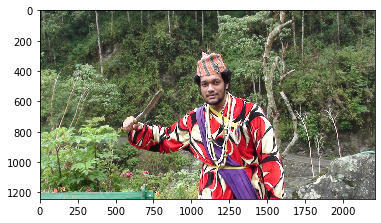

In [18]:
display_stats('test_images/4.JPG')

my_rank:2.0 
 BRISQUE: 55.09893798828125 
 TV:84.22862243652344 
 NIMA:5.3349127769470215+-2.5894577503204346


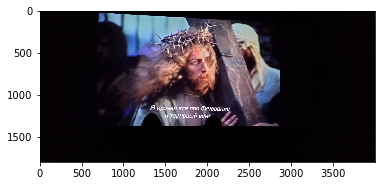

In [19]:
display_stats('test_images/2.jpg')

my_rank:5.0 
 BRISQUE: 40.58197021484375 
 TV:141.1936798095703 
 NIMA:5.681519508361816+-2.914736270904541


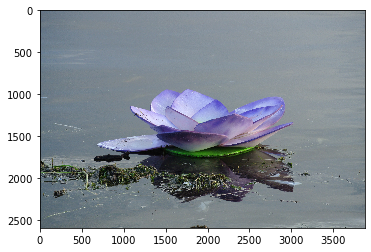

In [20]:
display_stats('test_images/5.JPG')